In [1]:
import os
from itertools import product
import config
import json
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import util
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
get_model_name = lambda dataset, model_type, curriculum: os.path.join(dataset + ("_" + model_type) + "_" + curriculum.split(".")[0])


In [2]:
experiments =[(get_model_name(dataset, model_type, curriculum), dataset, model_type, curriculum) for dataset, model_type, curriculum in product(config.datasets, config.model_types, config.baseline_curricula)]
experiments.extend([(get_model_name(dataset, model_type, model_type + curriculum), dataset, model_type, model_type + curriculum) for dataset, model_type, curriculum  in (product(config.datasets, config.model_types, config.influence_curricula))])
experiments_to_include = [os.path.basename(j[0]) for j in experiments]


In [3]:
import util
from tqdm import tqdm

In [ ]:
cache_path = "./plotting_notebooks/cache/pretraining_metrics.pkl"


if not os.path.exists(cache_path):
    api = wandb.Api()


    project_path = "loriss/pretraining"

    metric_path="train/loss"
    runs = api.runs(project_path)


    data = []
    for run in tqdm(runs):
        train = run.history(keys=["train/loss"]).set_index("_step") 
        eval = run.history(keys=["eval/loss"]).set_index("_step")
        
        epoch = run.history(keys=["train/epoch"]).set_index("_step")
        epoch["model"] = run.name  
        data.append(epoch.join(train).join(eval) )
    df = pd.concat(data, ignore_index=True)


    df["dataset"] = df["model"].apply(util.get_dataset)
    df["curriculum"] = df["model"].apply(util.get_curriculum_name)
    df.to_pickle(cache_path)

else:
    print("Reusing cached results")

df = pd.read_pickle(cache_path)




100%|██████████| 83/83 [01:40<00:00,  1.21s/it]


In [ ]:
# df = pd.read_csv(os.path.join("./plotting_notebooks/cache/","pretraining_metrics.csv"))

# print("not included in experiments but eval exists ", [model  for model in df["model"].unique() if not any([os.path.basename(model) == e for e in experiments_to_include])])
# print("to include in plots but eval doesn not exist ")
# t = [model  for model in experiments_to_include if  model not in [os.path.basename(mm) for mm in df["model"].unique()]]
# print(len(t), t)
# filter by experiments included in paper
df = df[df["model"].apply(lambda x: os.path.basename(x) in experiments_to_include)]

not included in experiments but eval exists  ['models/babylm_2024_10m_curriculum_llama_llama_influence_incr_cp_lognorm', 'models/babylm_2024_10m_curriculum_llama_llama_influence_decr_cp_lognorm']
to include in plots but eval doesn not exist 
0 []


In [6]:
df["model_type"] = df["model"].apply(lambda x: "roberta" if "roberta" in x else "llama")

<Figure size 200x500 with 0 Axes>

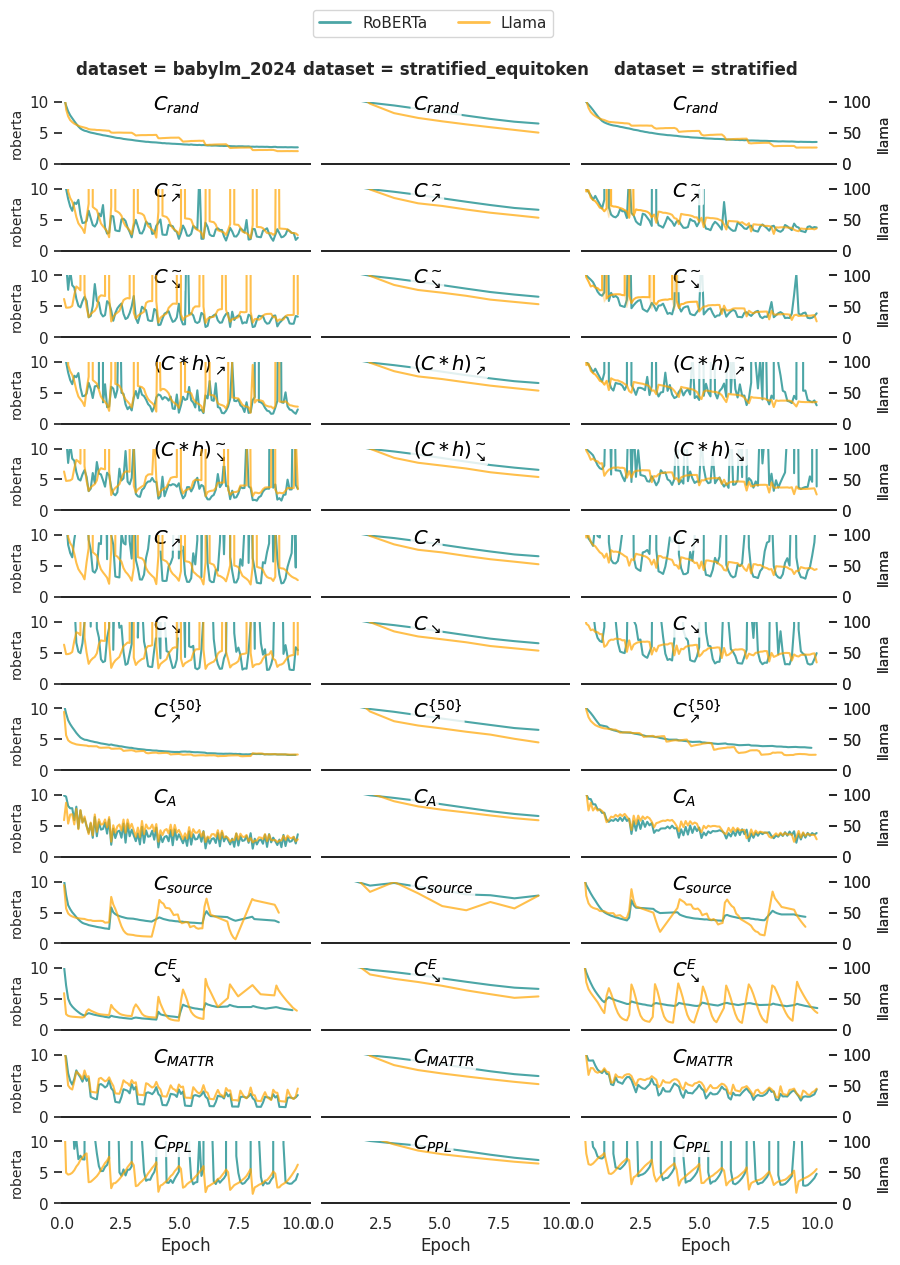

<Figure size 200x500 with 0 Axes>

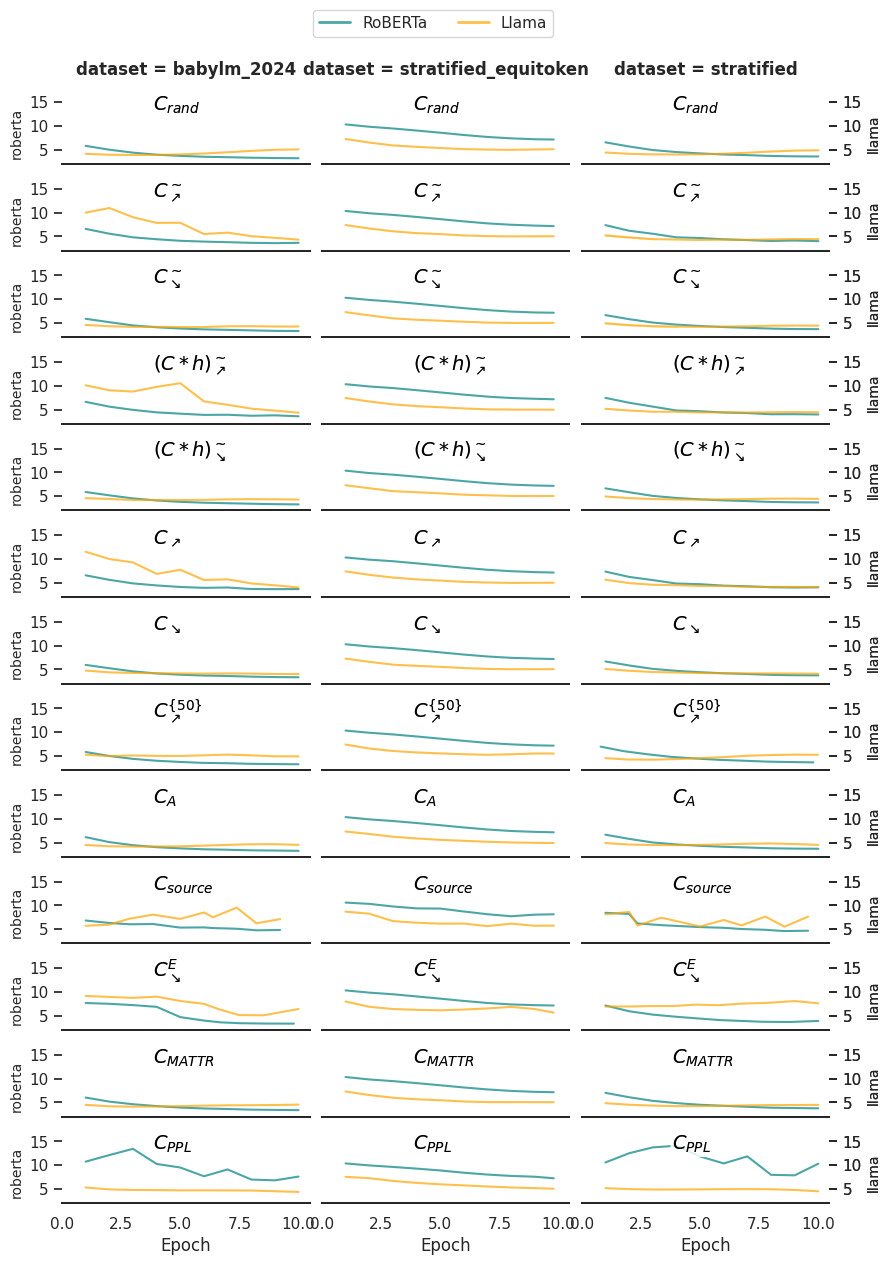

In [14]:
WIDTH_TWO_COL = 2
FONT_SIZE = 10


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn.axisgrid")
warnings.filterwarnings("ignore", category=UserWarning)

def plot(metric_path="train/loss"):
    plt.figure(figsize=(WIDTH_TWO_COL, 5))
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    g = sns.FacetGrid(df, row="curriculum", hue="model_type",col="dataset", aspect=3, height=1.1, sharey=False, sharex=True,margin_titles=True)
    def facetgrid_two_axes(data, x_name, y1_name, y2_name, ylabel1, ylabel2,color=None,label=None):
        ax1 = plt.gca()
        sns.lineplot(x=data[data["model_type"] == "roberta"][x_name], y=data[data["model_type"] == "roberta"][y1_name], alpha=.7, ax=ax1,color="teal")
        ax1.set_ylabel("roberta",fontsize=10)
        if "train/loss" in metric_path:
            ax1.set_ylim(0,10)
        else:
            ax1.set_ylim(2,15)

       
        if "babylm_2024_10m_curriculum" == data.iloc[0]["dataset"]:
            ax1.set_ylabel("roberta", fontsize=10)
        else:
            ax1.set_ylabel("", fontsize=10)
            ax1.set_yticks([])


        ax2 = ax1.twinx()
        sns.lineplot(x=data[data["model_type"] == "llama"][x_name], y=data[data["model_type"] == "llama"][y1_name], alpha=.7, ax=ax2, color="orange")
        if "stratified_10m_curriculum" == data.iloc[0]["dataset"]:
            ax2.set_ylabel("llama", fontsize=10)
        else:
            ax2.set_ylabel("", fontsize=10)
            ax2.set_yticks([])

        if "train/loss" in metric_path:
            ax2.set_ylim(0,100)
        else:
            ax2.set_ylim(2,15)

    g.map_dataframe(facetgrid_two_axes, x_name="train/epoch", y1_name=metric_path, y2_name=metric_path, ylabel1="roberta", ylabel2="llama")
    # g.map(sns.lineplot, "train/epoch", metric_path, linewidth=2,marker="o")
    def label(x, color, label):
        ax = plt.gca()
        ax.text((WIDTH_TWO_COL/3)-0.3, 0.95, util.rename(x.iloc[0]), fontweight="bold", color="black", fontsize=FONT_SIZE+4,
                ha="left", va="center", transform=ax.transAxes,
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1',alpha=0.6))

        ax.set_xlim(0,)
    g.map(label, "model")
    g.set_titles("{col_name}","", size=12)
    # g.set_axis_labels( "Epoch","",)
    g.set_axis_labels("Epoch", None)
    g.despine(left=True)
    g.figure.subplots_adjust(hspace=0.4, wspace=0.05)    
    for ax in g.axes.flat:
        title = ax.get_title()
        ax.set_title(title.replace("_10m_curriculum",""), fontsize=12,pad=20,fontweight="bold")
        ax.tick_params(labelsize=11)
    handles = [
        plt.Line2D([0], [0], color="teal", lw=2, label="RoBERTa",alpha=.7),
        plt.Line2D([0], [0], color="orange", lw=2, label="Llama",alpha=.7),
    ]
    g.fig.legend(handles=handles, loc="upper center", ncol=2, fontsize=11, bbox_to_anchor=(0.5, 0.95),facecolor='white')


    util.save_pdf(g, metric_path.replace('/', '_'))
    plt.show()
import util




plot("train/loss")
plot("eval/loss")